In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Load dataset 
url = "https://raw.githubusercontent.com/MaharLeika18/Data-Mining---Python/refs/heads/main/Titanic-Dataset.csv"
data = pd.read_csv(url)

In [ ]:
# Clean and preprocess the data
data = data.drop_duplicates()   # Drop dupes
data['Age'] = data['Age'].fillna(data['Age'].median())  # Fill missing cells in Age w/ median
data['Fare'] = data['Fare'].fillna(data['Fare'].median()) # Same but in Fare
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0]) # Same but in Embarked and fill w/ mode

# Drop columns that won't be used
data = data.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)

# Create new columns for:
data['Family'] = data['SibSp'] + data['Parch'] + 1  # Total family members on board
data['IsAlone'] = (data['Family'] == 1).astype(int) # Whether they are travelling alone or not

# Convert text values into measurable numerical values
data['Sex'] = data['Sex'].map({'male':0, 'female':1})   # Male = 0, Female = 1
data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2}) # S = 0, C = 1, Q = 2

In [4]:
# Preview the cleaned data, see what columns can be used for analysis
print(data.describe()) # Summary
data.sample(5)  # Random 5 rows


         Survived      Pclass         Sex         Age       SibSp       Parch  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642    0.352413   29.361582    0.523008    0.381594   
std      0.486592    0.836071    0.477990   13.019697    1.102743    0.806057   
min      0.000000    1.000000    0.000000    0.420000    0.000000    0.000000   
25%      0.000000    2.000000    0.000000   22.000000    0.000000    0.000000   
50%      0.000000    3.000000    0.000000   28.000000    0.000000    0.000000   
75%      1.000000    3.000000    1.000000   35.000000    1.000000    0.000000   
max      1.000000    3.000000    1.000000   80.000000    8.000000    6.000000   

             Fare    Embarked      Family     IsAlone  
count  891.000000  891.000000  891.000000  891.000000  
mean    32.204208    0.361392    1.904602    0.602694  
std     49.693429    0.635673    1.613459    0.489615  
min      0.000000    0.000000    1.000000    0

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Family,IsAlone
601,0,3,"Slabenoff, Mr. Petco",0,28.0,0,0,7.8958,0,1,1
619,0,2,"Gavey, Mr. Lawrence",0,26.0,0,0,10.5000,0,1,1
351,0,1,"Williams-Lambert, Mr. Fletcher Fellows",0,28.0,0,0,35.0000,0,1,1
604,1,1,"Homer, Mr. Harry (""Mr E Haven"")",0,35.0,0,0,26.5500,1,1,1
613,0,3,"Horgan, Mr. John",0,28.0,0,0,7.7500,2,1,1


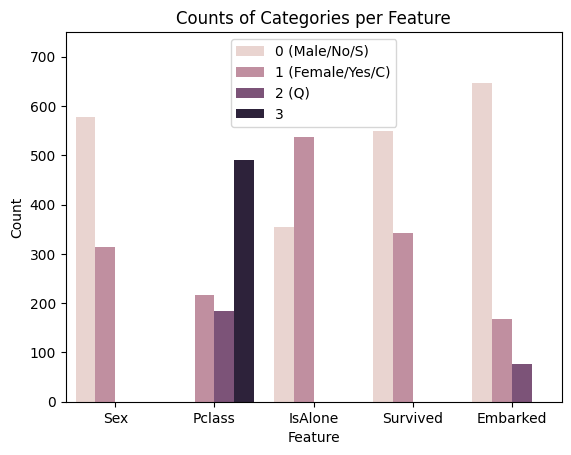

In [ ]:
# Display the count of categories across multiple columns - Bar chart
categories = ['Sex', 'Pclass', 'IsAlone', 'Survived', 'Embarked']
converted = data[categories].melt(var_name='Feature', value_name='Category')  # Convert the columns into rows

sns.countplot(data=converted, x='Feature', hue='Category')
plt.title("Counts of Categories per Feature")
plt.ylabel("Count")
plt.xlabel("Feature")
plt.ylim(top=750)
plt.legend(["0 (Male/No/S)", "1 (Female/Yes/C)", "2 (Q)", "3"])

plt.show()



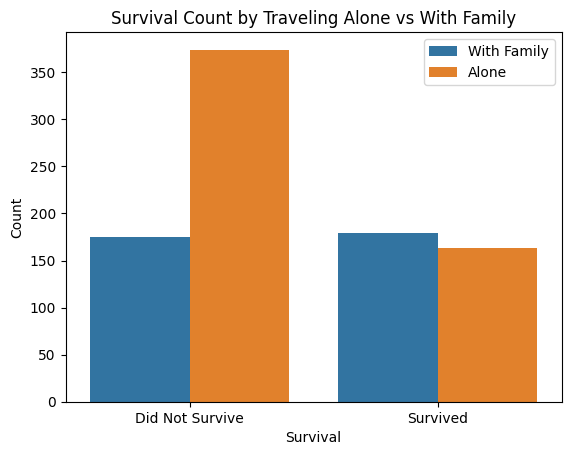

In [21]:
# Compare survival rate of passengers based on whether they travelled alone or not - Bar
sns.countplot(x='Survived', hue='IsAlone',data=data)

plt.title("Survival Count by Traveling Alone vs With Family")
plt.xlabel("Survival")
plt.ylabel("Count")
plt.xticks([0, 1], ["Did Not Survive", "Survived"])
plt.legend(["With Family", "Alone"])

plt.show()

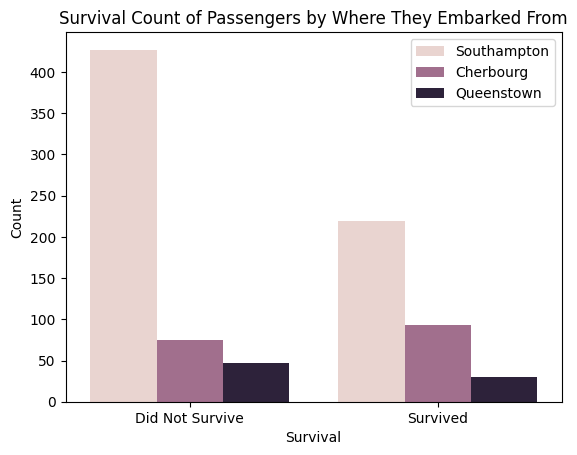

In [23]:
# Compare survival rate of passengers based on where they embarked from - Bar
sns.countplot(x='Survived', hue='Embarked',data=data)

plt.title("Survival Count of Passengers by Where They Embarked From")
plt.xlabel("Survival")
plt.ylabel("Count")
plt.xticks([0, 1], ["Did Not Survive", "Survived"])
plt.legend(["Southampton", "Cherbourg", "Queenstown"])

plt.show()


In [8]:
# Compare fare of passengers that survived and those that didn't - Scatter chart

In [9]:
# Display the survival rate of passengers based on their age and gender - Scatter 


In [10]:
# Compare family sizes of passengers that survived and those that didn't - Scatterplot


In [11]:
# Compare survival rate of passengers based on passenger class and fare - Scatter
